<a href="https://colab.research.google.com/github/bmoretz/Notebooks/blob/master/Hands-OnMachineLearning/ch_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Projection Methods

`Build 3D dataset`

In [0]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

# PCA using SVD decomposition

Note: the svd() function returns U, s and Vt, where Vt is equal to $\mathbf{V}^T$, the transpose of the matrix $\mathbf{V}$. Earlier versions of the book mistakenly said that it returned V instead of Vt. Also, Equation 8-1 should actually contain $\mathbf{V}$ instead of $\mathbf{V}^T$, like this:

$
\mathbf{V} =
\begin{pmatrix}
  \mid &\mid && \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

In [0]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [0]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [40]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [0]:
W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)

In [0]:
X2D_using_svd = X2D

# PCA using Scikit-Learn

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components =2)
X2D = pca.fit_transform(X)

In [45]:
pca.components_.T[:, 0]

array([-0.93636116, -0.29854881, -0.18465208])

In [46]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [47]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [48]:
np.allclose(X2D, -X2D_using_svd)

True

In [0]:
X3D_inv = pca.inverse_transform(X2D)

Recover the 3D points projected on the plane (PCA 2D subspace).

In [50]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [51]:
np.mean(np.sum(np.square(X3D_inv - X), axis = 1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [0]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

The reconstructions from both methods are not identical because Scikit-Learn's PCA class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [53]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The PCA object gives access to the principal components that it computed:

In [54]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [55]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

# Explained Variance Ratio

In [56]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [57]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that s is the diagonal of the matrix S):

In [58]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

# Visualization

In [0]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [0]:
class Arrow3D(FancyArrowPatch):
  def __init__(self, xs, ys, zs, *args, **kwargs):
    FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
    self._verts3d = xs, ys, zs
    
  def draw(self, renderer):
    xs3d, ys3d, zs3d = self._verts3d
    xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
    self.set_positions((xs[0], ys[0]),(xs[1], ys[1]))
    FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y

In [0]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

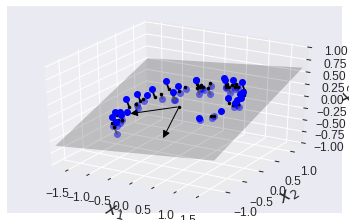

In [62]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

# Manifold Learning

In [0]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples =1000, noise=0.2, random_state=42)

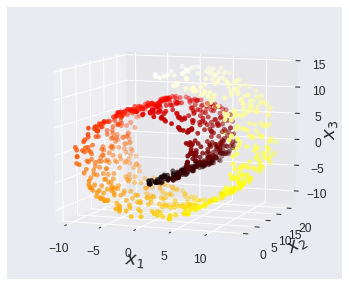

In [66]:
axes = [-11, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap= plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()